In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline


Extract the zip files to data directory

In [2]:
sales_df = pd.read_csv('data/sales_train_v2.csv')
item_df = pd.read_csv('data/items.csv')
item_category_df = pd.read_csv('data/item_categories.csv')
shop_df = pd.read_csv('data/shops.csv')
sample_df = pd.read_csv('data/sample_submission.csv.gz')
test_df = pd.read_csv('data/test.csv')

We will be needing day of month column date_block_num will be enough for month and year so lets drop it 

In [3]:
sales_df['date'] =  pd.to_datetime( sales_df['date'] , format= '%d.%m.%Y' )
# sales_df['month'] = sales_df['date'].dt.month
sales_df['day'] = sales_df['date'].dt.day
sales_df= sales_df.drop('date' , axis =1)


Lets examine our sales data

In [4]:
sales_df.head(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day
0,0,59,22154,999.0,1.0,2
1,0,25,2552,899.0,1.0,3


In [5]:
item_category_df.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [6]:
test_df.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [7]:
import gc

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

downcast_dtypes(sales_df)

downcast_dtypes(item_df);


Lets first check  wether all item id and shop id in the training set is there in test set too .  

In [8]:
 set( test_df.shop_id.unique()).issubset(set(  sales_df.shop_id.unique())  )

True

In [9]:
set( test_df.item_id.unique()).issubset(set(  sales_df.item_id.unique())  )

False

In [10]:
set( test_df.item_id.unique()).issubset(set(  item_df.item_id.unique())  )

True

Looks like all item id in the test set are not present on the training, Anyways  but all the item id are present in the item data frame. Lets explore further.
after exploring our sales data will be combined from shop and item category data.

In [11]:
sales_df.head(3)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,day
0,0,59,22154,999.0,1.0,2
1,0,25,2552,899.0,1.0,3
2,0,25,2552,899.0,-1.0,5


**First lets remove some outliers** 

items who were sold abnormaly large
Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
shops where items sales were abormaly large
Sale volume outliers: shop id [27 25 12 55]
per day sales max value {2169} , min value {-22} 
item price max value {307980} , min value {-1} 


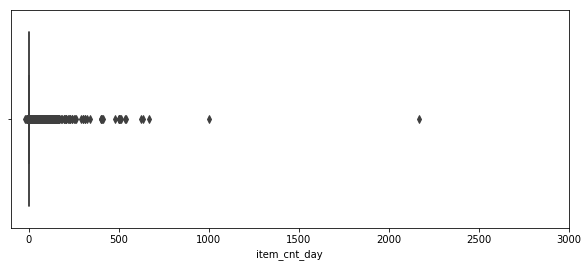

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales_df['item_cnt_day'])
print('items who were sold abnormaly large')
print('Sale volume outliers:',sales_df['item_id'][sales_df['item_cnt_day']>500].unique())

print('shops where items sales were abormaly large' )
print('Sale volume outliers: shop id',sales_df['shop_id'][sales_df['item_cnt_day']>500].unique())
print( 'per day sales max value {%d} , min value {%d} '  %( sales_df.item_cnt_day.max() ,  sales_df.item_cnt_day.min() ) )
print( 'item price max value {%d} , min value {%d} '  %( sales_df.item_price.max() ,  sales_df.item_price.min() ) )

#sns.boxplot( x=sales_df['item_price'] )

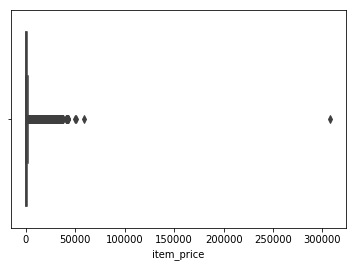

In [21]:
sns.boxplot( x=sales_df['item_price'] )

Item price is -1 thats an outlier , similarly minimum sales on a particular day was -22 . Thats's ok . Upon verfying that item price greater than 300000 was actually a bulk order. But sales count was greater than 2000 . Thats' clear outlier.  Lets plot them shopwise and item category wise.

In [22]:
shopwise_monthly_sales = sales_df.groupby( [ 'shop_id' , 'date_block_num' ] ).agg( 
                                        { 'item_cnt_day':['sum', 'mean' , 'median' ,'max' , 'min' ,'std' ] } )

Lets say for shop number 25. 

In [27]:
shop_25_monthly =  shopwise_monthly_sales.loc[ 25 , :  ]

In [29]:
shop_25_monthly.head(1)

item_cnt_day                                      
                        sum      mean median   max  min       std
date_block_num                                                   
0                    8215.0  1.178454    1.0  13.0 -1.0  0.695549

Lets plot that out

[Text(0, 0.5, 'Total sales'),
 Text(0.5, 0, 'Month '),
 Text(0.5, 1.0, "Shop id 25 's monthly sale'")]

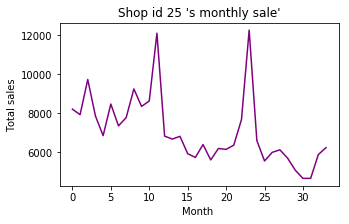

In [36]:
ig, ax = plt.subplots(figsize=(5, 3))

# Add the x-axis and the y-axis to the plot
ax.plot(shopwise_monthly_sales.loc[ 25 , : ].index.values,
        shopwise_monthly_sales.loc[ 25 , : ].item_cnt_day.iloc[:,0],
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Month ",
       ylabel="Total sales",
       title="Shop id 25 's monthly sale'")

#shopwise_monthly_sales.index.get_level_values('shop_id').values


We should extend this for multiple shops 

In [31]:
def draw_many_plots( df , target_column,  agg_column , agg_sub_column, width =3 , label =''   ):
    
    n = len( np.unique(df.index.get_level_values( target_column ).values ) )
    arr = np.unique(df.index.get_level_values( target_column ).values )
    ig, ax = plt.subplots( n // width , width  , figsize = (20 , 84 ) )
    for i,ele in enumerate(arr):
        j= i % width
        k = i // width
        ax[k][j].plot( df.loc[ele , :].index.values ,  df.loc[ ele , : ][agg_column].loc[:,agg_sub_column] )
        ax[k][j].title.set_text( label + str(i) + '  monthly sales'  )
        if k == n//width-1:
            ax[k][j].get_xaxis().set_visible(True)
        else:
            ax[k][j].get_xaxis().set_visible(False)
            

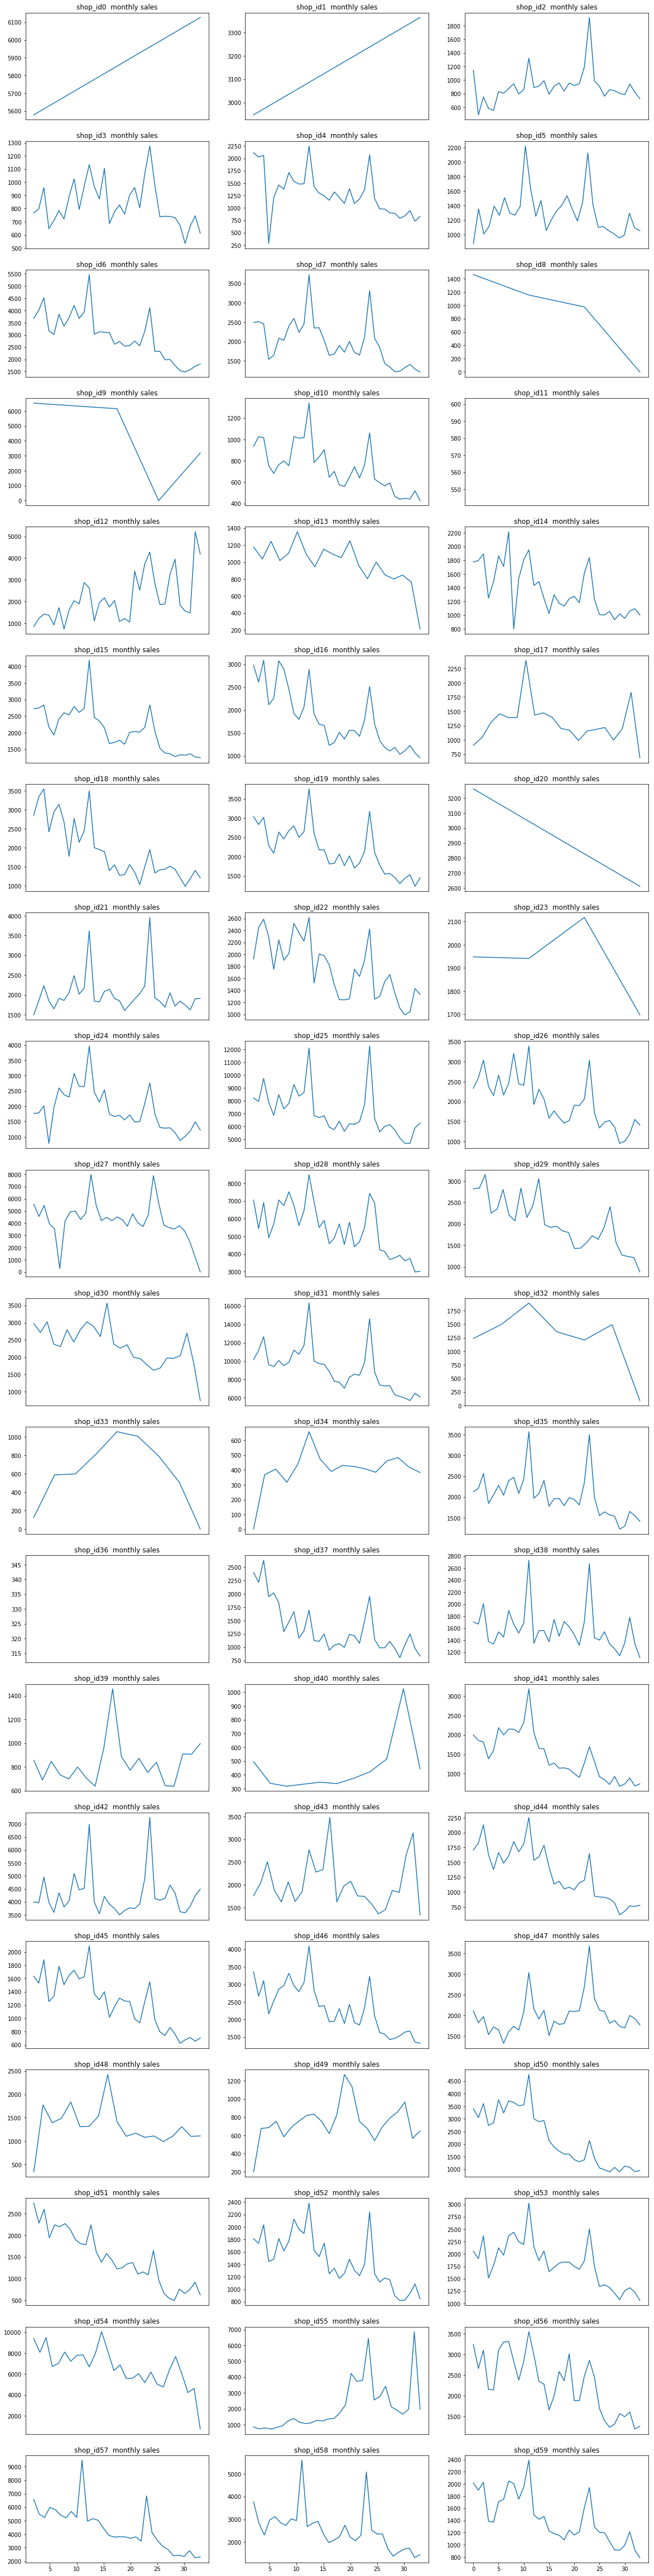

In [32]:
draw_many_plots( shopwise_monthly_sales , 'shop_id' , 'item_cnt_day' , 'sum'  , 3  , 'shop_id' )

Similarly lets analyze item category wise .

In [33]:
sales_item_merged = pd.merge( sales_df , item_df , on = 'item_id' , how = 'inner'  )

In [34]:
category_wise_monthly_sale = sales_item_merged.groupby( ['item_category_id' , 'date_block_num' ] ).agg( 
    { 'item_cnt_day':['sum' , 'max' , 'mean' ,'median' , 'min' ,'std' ] } )

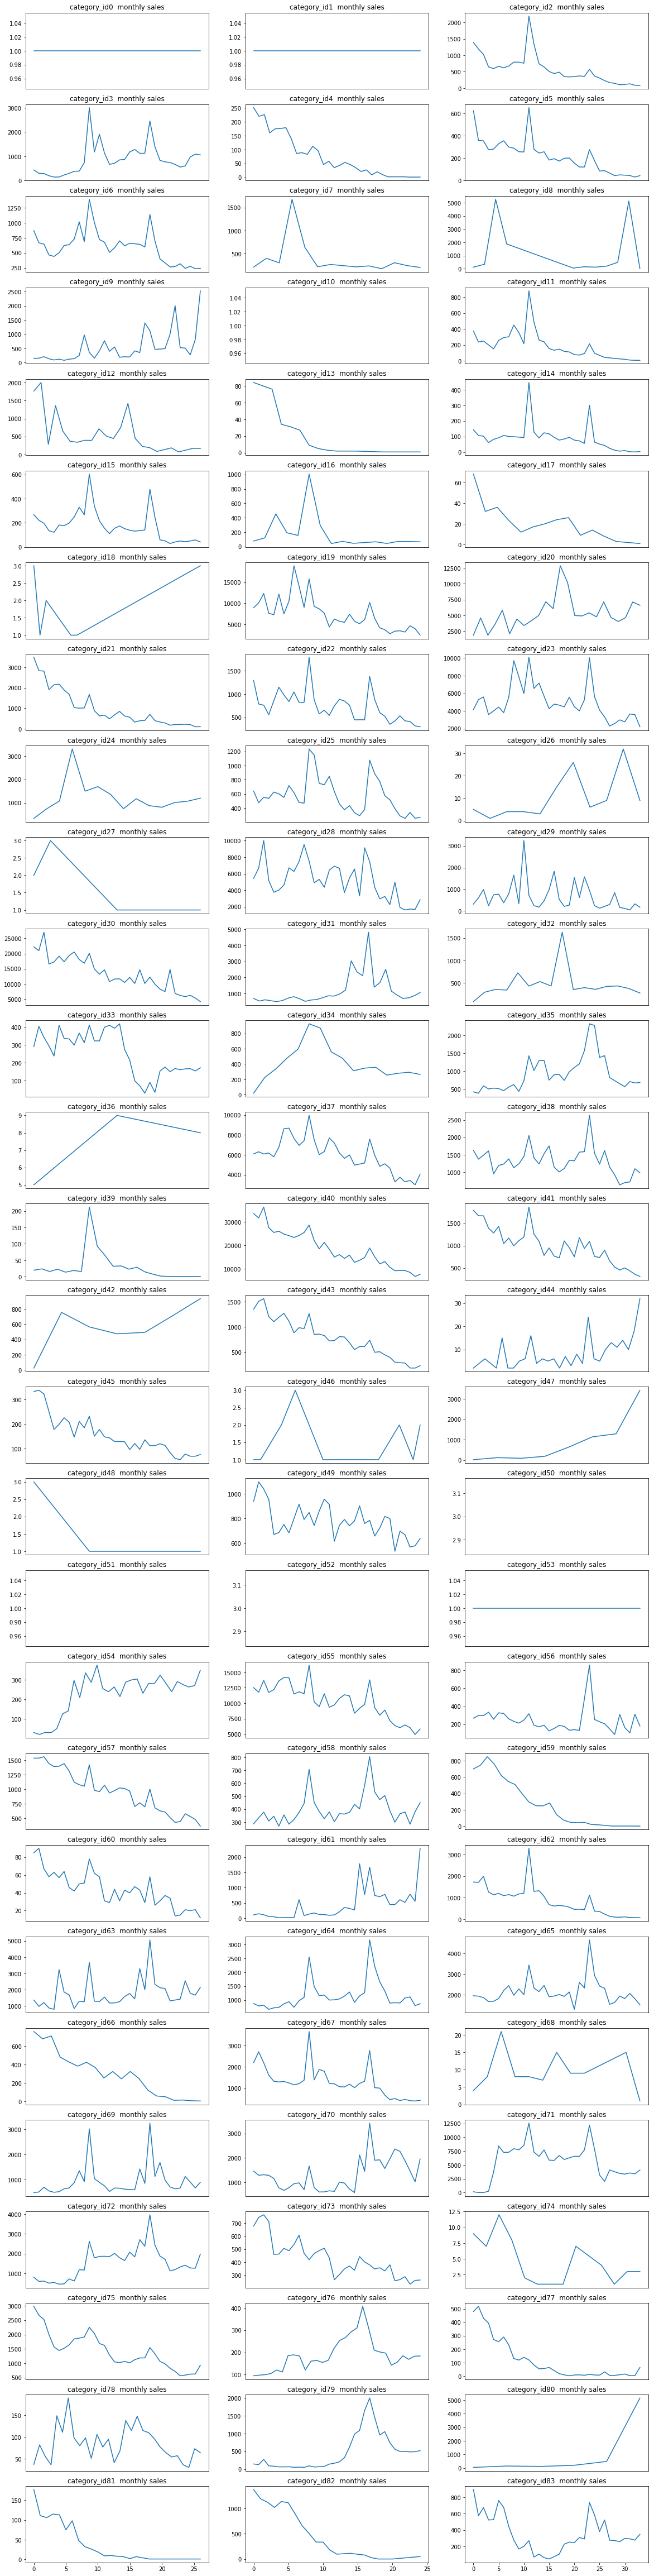

In [35]:
draw_many_plots( category_wise_monthly_sale , 'item_category_id' , 'item_cnt_day' , 'sum'  , 3 , 'category_id' )

Enough of EDA Lets contruct some features from the data. The task is similar to that done in the assignment four.

In [12]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']
from itertools import product


# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_df['date_block_num'].unique():
    cur_shops = sales_df.loc[sales_df['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_df.loc[sales_df['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    
    
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)





In [13]:
# Groupby data to get shop-item-month aggregates
gb = sales_df.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)




/home/deepanshu/Documents/udacity_project_plagarism/workspace_udacity/lib/python3.5/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [14]:
# Same as above but with shop-month aggregates
gb = sales_df.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)



In [15]:
# Same as above but with item-month aggregates
gb = sales_df.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)



In [16]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [17]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0
